In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime

# Vector Autoregression Model

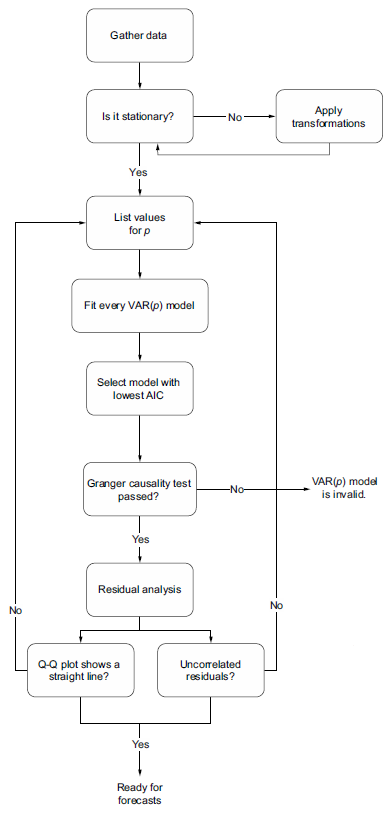

\begin{align}
VAR(p):
    \begin{bmatrix}
        y_{1,t}\\
        y_{2,t}
    \end{bmatrix}
    =
    \begin{bmatrix}
        C_1\\
        C_2
    \end{bmatrix}
    +
    \begin{bmatrix}
        \phi_{1,1}^1 & \phi_{1,2}^1\\
        \phi_{2,1}^1 & \phi_{2,2}^1
    \end{bmatrix}
    \begin{bmatrix}
        y_{1,t-1}\\
        y_{2,t-1}
    \end{bmatrix}
    +
    …
    +
    \begin{bmatrix}
        \phi_{1,1}^p & \phi_{1,2}^p\\
        \phi_{2,1}^p & \phi_{2,2}^p
    \end{bmatrix}
    \begin{bmatrix}
        y_{1,t-p}\\
        y_{2,t-p}
    \end{bmatrix}
    +
    \begin{bmatrix}
        ϵ_{1,t}\\
        ϵ_{2,t}
    \end{bmatrix}
\end{align}

## Identifying VAR process

<Axes: xlabel='date', ylabel='realcons'>

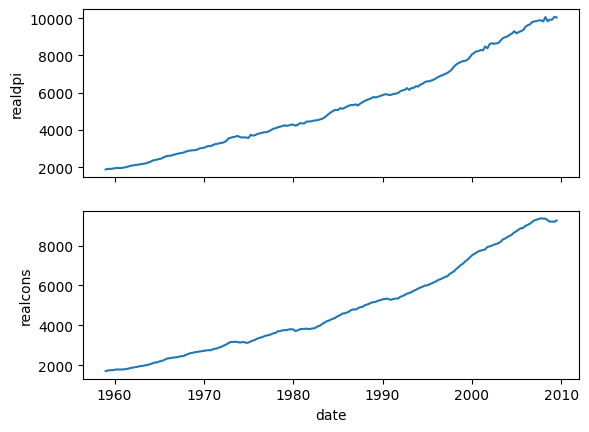

In [2]:
## Forecasting both real disposable income and real consumption ##
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# Import data
gdp_df = sm.datasets.macrodata.load_pandas().data
gdp_df['date'] = pd.to_datetime(gdp_df.year.astype(int).astype(str) + 'Q' + gdp_df.quarter.astype(int).astype(str))

# Plot both variables of interest
fig, axs = plt.subplots(2,1, sharex=True)
sns.lineplot(x=gdp_df.date, y=gdp_df.realdpi, ax=axs[0])
sns.lineplot(x=gdp_df.date, y=gdp_df.realcons, ax=axs[1])

# Intuition from graph:
# Both curves have very similar shape across time -> possibly suitable for VAR(p) model
# Fit macroeconomics theory -> disposable income positively impact consumption, vice versa

In [3]:
# Test for stationary on realdpi
ADF_result = adfuller(gdp_df['realdpi'])
print("ADF_null:", ADF_result)

# Results:
# p-value = 1 > 0.05
# ADF statistic = 2.99 > rejection zone (lies outside)
# Do not reject null hypothesis, cannot conclude time series is stationary.

# Applying first order differencing
dpi_diff = np.diff(gdp_df['realdpi'], n=1)

# Test for stationary again
ADF_diff_result = adfuller(dpi_diff)
print("ADF_1_diff:", ADF_diff_result)

# Results:
# p-value = 1.4e^-14 > 0.05
# ADF statistic = -8.86 < rejection zone (lies within)
# Reject null hypothesis, conclude time series is stationary.

ADF_null: (2.986025351954683, 1.0, 2, 200, {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225}, 2014.6630929800756)
ADF_1_diff: (-8.864893340673007, 1.4493606159108096e-14, 1, 200, {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225}, 2009.0790249915815)


In [4]:
# Test for stationary on realcons
ADF_result = adfuller(gdp_df['realcons'])
print("ADF_null:", ADF_result)

# Results:
# p-value = 0.998 > 0.05
# ADF statistic = 1.55 > rejection zone (lies outside)
# Do not reject null hypothesis, cannot conclude time series is stationary.

# Applying first order differencing
cons_diff = np.diff(gdp_df['realcons'], n=1)

# Test for stationary again
ADF_diff_result = adfuller(cons_diff)
print("ADF_1_diff:", ADF_diff_result)

# Results:
# p-value = 6.5e^-04 > 0.05
# ADF statistic = -4.20 < rejection zone (lies within)
# Reject null hypothesis, conclude time series is stationary.

ADF_null: (1.549912338050964, 0.9976992503412904, 4, 198, {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}, 1793.172616888144)
ADF_1_diff: (-4.204306080845247, 0.0006479282158627571, 3, 198, {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}, 1784.2903520562793)


In [5]:
## Determining the order p for VAR process ##
from itertools import product
from statsmodels.tsa.statespace.varmax import VARMAX

# Spliting differenced dataset into train & test sets
df_diff = pd.DataFrame({'dpi_diff': dpi_diff, 'cons_diff': cons_diff})
train = df_diff.loc[:161,]
test = df_diff.loc[162:,]

# Fitting data to all unique VAR(p) models
def optimise_VAR(endog, p) -> pd.DataFrame:
    """
    Args:
        endog: endogenous data to be fitted
        p: maximum possible values of p

    Returns: DataFrame containing AIC results for different (p) orders
    """
    results = []

    for i in range(1, p):
            model = VARMAX(endog, order=(i, 0)).fit()
            aic = model.aic
            results.append([(i), aic])

    result_df = pd.DataFrame(results, columns=['(p)', 'AIC']).sort_values(by='AIC').reset_index(drop=True)

    return result_df

# Using Akaike information criterion to select optimal model
AIC_result = optimise_VAR(train, 15)
AIC_result

# Intuition:
# Select VAR(3) as optimal model since it has the lowest AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

,(p),AIC
0,3,3123.070078
1,5,3123.708523
2,6,3126.855598
3,4,3129.194047
4,2,3130.091668
5,7,3133.398275
6,1,3134.333343
7,8,3137.149013
8,9,3140.367180
9,10,3147.838722


In [6]:
## Determine whether one time series is predictive of another ##
from statsmodels.tsa.stattools import grangercausalitytests

# Applying Granger causality test on whole differenced data (ie. train + test)
# H0: second column does not Granger-cause first column
granger_1 = grangercausalitytests(df_diff, [3])                                     # only at lag 3
granger_2 = grangercausalitytests(df_diff.loc[:, ['cons_diff', 'dpi_diff']], [3])

# Intuition:
# Both variables return p-value < 0.05
# Reject H0 and conclude realdpi Granger-causes realcons & realcons Granger-causes realdpi
# VAR(3) model is valid


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


      lb_stat  lb_pvalue
1    0.011641   0.914079
2    0.029410   0.985403
3    0.075796   0.994575
4    0.378020   0.984237
5    9.142892   0.103499
6    9.165748   0.164469
7    9.270487   0.233815
8   10.812127   0.212573
9   13.318498   0.148716
10  15.287698   0.121920
     lb_stat  lb_pvalue
1   0.023757   0.877505
2   0.068698   0.966234
3   0.068777   0.995301
4   0.235628   0.993582
5   0.377556   0.995925
6   0.787230   0.992412
7   1.015086   0.994581
8   2.150240   0.976056
9   2.436944   0.982531
10  2.442617   0.991686


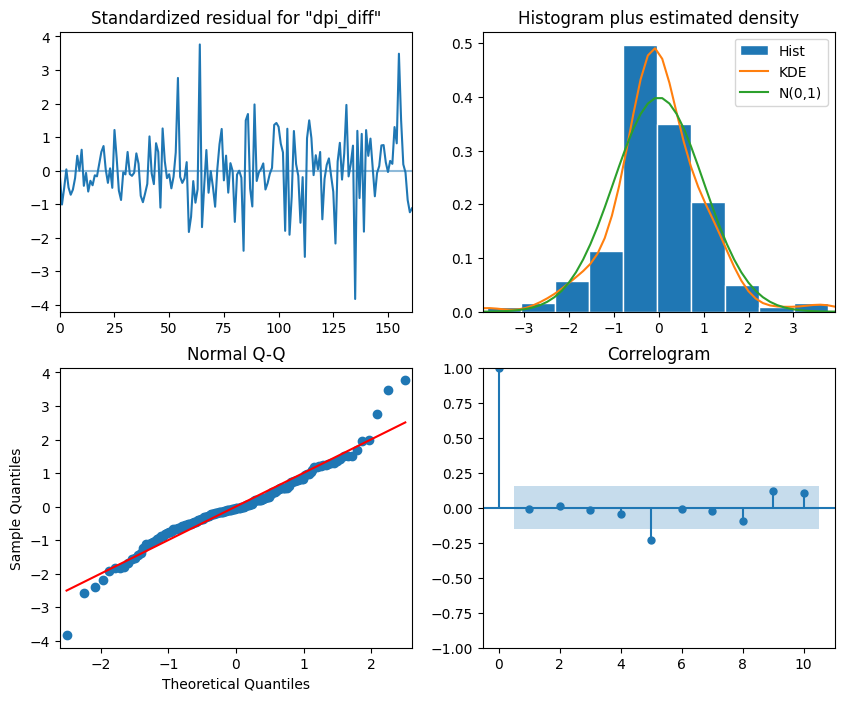

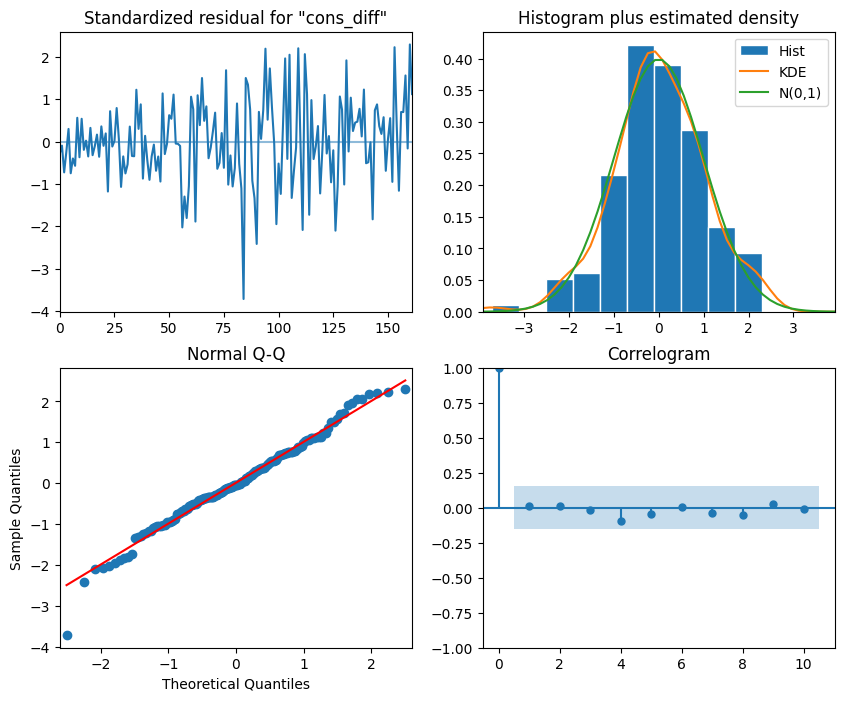

In [7]:
## Assessing the VAR model ##
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assessing exogenous variables
VAR_model_fit = VARMAX(train, order=(3, 0)).fit()
# print(VAR_model_fit.summary())
VAR_model_fit.plot_diagnostics(figsize=(10, 8), variable=0);    # Qualitative residual analysis on realdpi

# Intuition:
# top left: no trend in residual, variance fairly constant over time -> resembles white noise
# top right: fairly symmetrical distribution -> residuals are approximately normally distributed
# bottom left: fairly straight y=x line, but with curvature at extremities -> residuals seem to be normally distributed
# bottom right: no significant coefficient beyond lag 0, except lag 5 which is likely due to chance -> no autocorrelation
# Properties of white noice: normally distributed, stationary, uncorrelated
# Residuals resemble white noise -> errors are random

VAR_model_fit.plot_diagnostics(figsize=(10, 8), variable=1);    # Qualitative residual analysis on realcons

# Intuition:
# top left: no trend in residual, variance fairly constant over time -> resembles white noise
# top right: fairly symmetrical distribution -> residuals are approximately normally distributed
# bottom left: fairly straight y=x line -> residuals seem to be normally distributed
# bottom right: no significant coefficient beyond lag 0 -> no autocorrelation
# Properties of white noice: normally distributed, stationary, uncorrelated
# Residuals resemble white noise -> errors are random

# Quantitative residual analysis - Ljung-Box test (model's residuals are uncorrelated?)
VAR_residuals = VAR_model_fit.resid
print(acorr_ljungbox(VAR_residuals['dpi_diff'], 10))    # Ljung-Box test on realdpi residuals for 10 lags

# Intuition from Ljung-Box test:
# H0: residuals are iid, no autocorrelation
# All p-value > 0.05, cannot reject null hypothesis at each lag
# Conclude that residuals are uncorrelated
# realdpi residuals are completely random

print(acorr_ljungbox(VAR_residuals['cons_diff'], 10))   # Ljung-Box test on realcons residuals for 10 lags

# Intuition from Ljung-Box test:
# H0: residuals are iid, no autocorrelation
# All p-value > 0.05, cannot reject null hypothesis at each lag
# Conclude that residuals are uncorrelated
# realcons residuals are completely random

# VAR(3) model fits our data well

## Forecasting VAR process

In [8]:
## Forecasting real disposable income and real consumption for next 1 year ##
from statsmodels.tsa.statespace.varmax import VARMAX

def rolling_forecast(endog,
                     train_len: int,
                     test_len: int,
                     window: int,
                     method: str) -> list:

    total_len = train_len + test_len

    # As time series increases by window period, new last value is extracted
    if method == 'last':
        dpi_pred_last = []
        cons_pred_last = []
        for i in range(train_len, total_len, window):
            dpi_last_value = endog.iloc[i-1]['realdpi']
            dpi_pred_last.extend([dpi_last_value] * window)
            cons_last_value = endog.iloc[i-1]['realcons']
            cons_pred_last.extend([cons_last_value] * window)
        return dpi_pred_last, cons_pred_last

    # As time series increases by window period, new VAR is calculated
    elif method == 'VAR':
        dpi_pred_var = []
        cons_pred_var = []
        for i in range(train_len, total_len, window):
            pred_var_model = VARMAX(endog.iloc[:i], order=(3, 0))
            res = pred_var_model.fit()
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred_readdpi = predictions.predicted_mean.iloc[-window:]['dpi_diff']
            oos_pred_readcons = predictions.predicted_mean.iloc[-window:]['cons_diff']
            dpi_pred_var.extend(oos_pred_readdpi)
            cons_pred_var.extend(oos_pred_readcons)
        return dpi_pred_var, cons_pred_var

# Forecasting using last value and VAR(3)
TRAIN_LEN = len(train)
TEST_LEN = len(test)
WINDOW = 4      # to forecast 4 timestep into future (equivalent to 1 year)

# Note: input is actual data, since last value method don't require differencing
pred_last = rolling_forecast(gdp_df.loc[:,['realcons','realdpi']], TRAIN_LEN, TEST_LEN, WINDOW, 'last')

# Note: input is differenced data
pred_var = rolling_forecast(df_diff, TRAIN_LEN, TEST_LEN, WINDOW, 'VAR')

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'realcons')

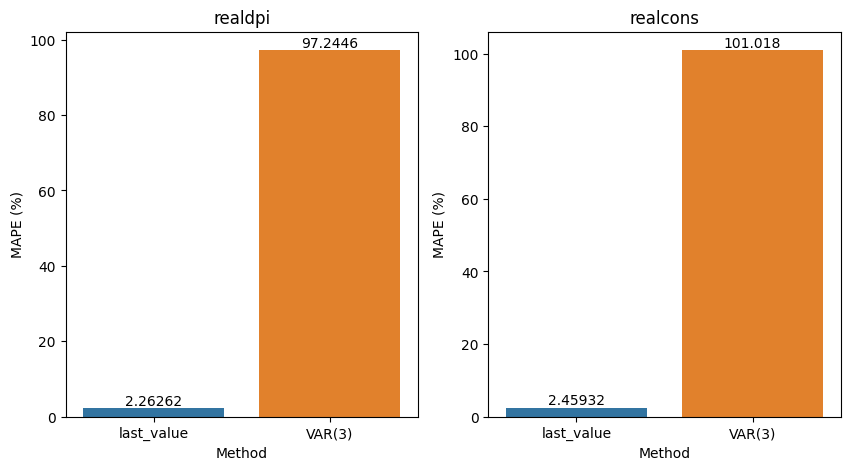

In [9]:
## Assessing prediction models ##

# Calculating MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true) * 100

mape_realdpi_last = mape(gdp_df.iloc[163:]['realdpi'], pred_last[0])
mape_realcons_last = mape(gdp_df.iloc[163:]['realcons'], pred_last[1])

mape_realdpi_VARMA = mape(test['dpi_diff'], pred_var[0])
mape_realcons_VARMA = mape(test['cons_diff'], pred_var[1])

# Plot MAPEs
mape_realdpi = {
    'name':['last_value', 'VAR(3)'],
    'mape':[mape_realdpi_last, mape_realdpi_VARMA]
    }

mape_realcons = {
    'name':['last_value', 'VAR(3)'],
    'mape':[mape_realcons_last, mape_realcons_VARMA]
    }

_, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(data=mape_realdpi, x='name', y='mape', ax=axs[0])
sns.barplot(data=mape_realcons, x='name', y='mape', ax=axs[1])
for ax in axs:
    ax.set_xlabel('Method')
    ax.set_ylabel('MAPE (%)')
    ax.bar_label(ax.containers[0])
axs[0].set_title('realdpi')
axs[1].set_title('realcons')

# Intuition:
# Graph does not make sense due to different data type - actual (last_value) vs differenced (VAR)
# MAPE of differenced data can be vastly different from MAPE of actual data (looking at VAR(3))

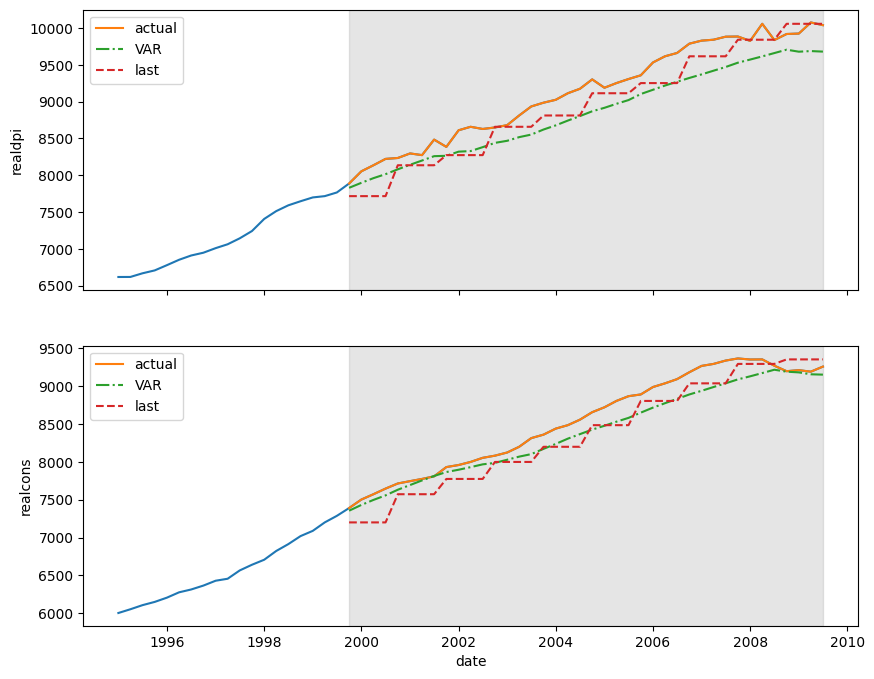

In [10]:
# Last 40 actual dataset
actual_test = gdp_df.iloc[163:][['date','realdpi','realcons']]

# 4 timestep rolling forecasted actual data
actual_test['realdpi_last'] = pd.Series(pred_last[0], index=actual_test.index)
actual_test['realcons_last'] = pd.Series(pred_last[1], index=actual_test.index)

# Inverse-transform the forecasted differenced dataset to original scale
actual_test['realdpi_varma'] = gdp_df.iloc[162]['realdpi'] + np.cumsum(pred_var[0])
actual_test['realcons_varma'] = gdp_df.iloc[162]['realcons'] + np.cumsum(pred_var[1])

# For diff dataset:
# 0 to 161 -> train set
# 162 to 201 -> test set
# Use first value's index of (diff) test set as initial Y_0 value index for inverse-transforming
# Then perform a cumulative sum

## Assessing prediction models ##
fig, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)

# Plot realdpi forecasts
sns.lineplot(data=gdp_df.loc[gdp_df.date>='1995',:], x='date', y='realdpi', ax=axs[0])
sns.lineplot(x=actual_test.date, y=actual_test.realdpi, label='actual', ax=axs[0])
sns.lineplot(x=actual_test.date, y=actual_test.realdpi_varma, label='VAR', linestyle='dashdot', ax=axs[0])
sns.lineplot(x=actual_test.date, y=actual_test.realdpi_last, label='last', linestyle='dashed', ax=axs[0])
axs[0].axvspan(datetime.datetime(1999,10,1), datetime.datetime(2009,7,1), color='grey', alpha=0.2)

# Plot realcons forecasts
sns.lineplot(data=gdp_df.loc[gdp_df.date>='1995',:], x='date', y='realcons', ax=axs[1])
sns.lineplot(x=actual_test.date, y=actual_test.realcons, label='actual', ax=axs[1])
sns.lineplot(x=actual_test.date, y=actual_test.realcons_varma, label='VAR', linestyle='dashdot', ax=axs[1])
sns.lineplot(x=actual_test.date, y=actual_test.realcons_last, label='last', linestyle='dashed', ax=axs[1])
axs[1].axvspan(datetime.datetime(1999,10,1), datetime.datetime(2009,7,1), color='grey', alpha=0.2)

# Intuition from forecast graph:
# VAR graphs follow general trend of observed values
# Baseline graphs move in steps, as we are forecasting constant value over 4 timesteps

# Calculating MAPE
# Reporting values and errors in original scale of data to make sense from business perspective
from sklearn.metrics import mean_absolute_percentage_error

mape_realdpi_var = mean_absolute_percentage_error(actual_test.realdpi, actual_test.realdpi_varma)
mape_realdpi_last = mean_absolute_percentage_error(actual_test.realdpi, actual_test.realdpi_last)

mape_realcons_var = mean_absolute_percentage_error(actual_test.realcons, actual_test.realcons_varma)
mape_realcons_last = mean_absolute_percentage_error(actual_test.realcons, actual_test.realcons_last)

Text(0.5, 1.0, 'realcons')

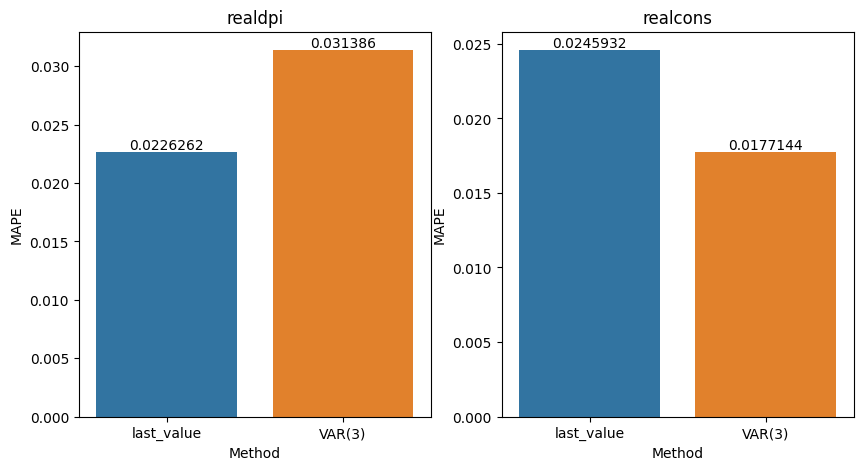

In [11]:
# Plot MAPEs
mape_realdpi = {
    'name':['last_value', 'VAR(3)'],
    'mape':[mape_realdpi_last, mape_realdpi_var]
    }

mape_realcons = {
    'name':['last_value', 'VAR(3)'],
    'mape':[mape_realcons_last, mape_realcons_var]
    }

_, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(data=mape_realdpi, x='name', y='mape', ax=axs[0])
sns.barplot(data=mape_realcons, x='name', y='mape', ax=axs[1])
for ax in axs:
    ax.set_xlabel('Method')
    ax.set_ylabel('MAPE')
    ax.bar_label(ax.containers[0])
axs[0].set_title('realdpi')
axs[1].set_title('realcons')

# Intuition:
# VAR(3) model performs worse than the baseline for forecasting realdpi.
# VAR(3) model performs better than the baseline for forecasting realcons.
# We hypothesize that in the case of realdpi, realcons is not predictive enough to
# make more accurate forecasts than the baseline, even though the Granger causality test passed.
# > Conclude that VAR(3) model is not sufficient to accurately forecast realdpi and realcons.
# > To use a variation of the SARIMAX model to predict realdpi: use two separate models,
# > which could include realdpi and realcons as exogenous variables,
# > while also potentially including moving average terms.

# Vector Autoregression Moving Average Model

## Identifying VARMA process

In [12]:
## To forecast both real disposable income and real consumption using VARMA ##
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# Import data
gdp_df = sm.datasets.macrodata.load_pandas().data
gdp_df['date'] = pd.to_datetime(gdp_df.year.astype(int).astype(str) + 'Q' + gdp_df.quarter.astype(int).astype(str))

# Applying first order differencing
dpi_diff = np.diff(gdp_df['realdpi'], n=1)
cons_diff = np.diff(gdp_df['realcons'], n=1)

In [13]:
## Determining the order p, q for VARMA process ##
from itertools import product
from statsmodels.tsa.statespace.varmax import VARMAX

# Spliting differenced dataset into train & test sets
df_diff = pd.DataFrame({'dpi_diff': dpi_diff, 'cons_diff': cons_diff})
train = df_diff.loc[:161,]
test = df_diff.loc[162:,]

# Fitting data to all unique VARMA(p,q) models
def optimise_VARMA(endog, order_list) -> pd.DataFrame:
    """
    Args:
        endog: endogenous data to be fitted
        order_list: list of possible (p,q) values

    Returns: DataFrame containing AIC results for different (p,q) orders
    """
    results = []

    for p, q in order_list:
            model = VARMAX(endog, order=(p, q)).fit()
            aic = model.aic
            results.append([(p,q), aic])

    result_df = pd.DataFrame(results, columns=['(p,q)', 'AIC']).sort_values(by='AIC').reset_index(drop=True)

    return result_df

# Defining posssible values of p, q (0 to 3)
VARMA_order_list = list(product(range(0,4), repeat=2))[1:]  # VARMA cannot take in (0,0) as order

# Using Akaike information criterion to select optimal model
AIC_result = optimise_VARMA(train, VARMA_order_list)
AIC_result

# Intuition:
# Select VARMA(3,0) or VAR(3) as optimal model since it has the lowest AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespac

,"(p,q)",AIC
0,"(3, 0)",3123.070078
1,"(2, 1)",3124.092931
2,"(1, 3)",3125.126782
3,"(3, 2)",3125.495057
4,"(2, 3)",3125.781136
5,"(1, 2)",3126.977833
6,"(3, 1)",3129.017100
7,"(1, 1)",3129.716539
8,"(2, 2)",3129.937837
9,"(2, 0)",3130.091668


In [14]:
## Determine whether one time series is predictive of another ##
from statsmodels.tsa.stattools import grangercausalitytests

# Applying Granger causality test on whole differenced data (ie. train + test)
# H0: second column does not Granger-cause first column
granger_1 = grangercausalitytests(df_diff, [3])                                     # only at lag 3
granger_2 = grangercausalitytests(df_diff.loc[:, ['cons_diff', 'dpi_diff']], [3])   # Use the largest order among (p,q)

# Intuition:
# Both variables return p-value < 0.05
# Reject H0 and conclude realdpi Granger-causes realcons & realcons Granger-causes realdpi
# VARMA(3,0) model is valid


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


      lb_stat  lb_pvalue
1    0.011641   0.914079
2    0.029410   0.985403
3    0.075796   0.994575
4    0.378020   0.984237
5    9.142892   0.103499
6    9.165748   0.164469
7    9.270487   0.233815
8   10.812127   0.212573
9   13.318498   0.148716
10  15.287698   0.121920
     lb_stat  lb_pvalue
1   0.023757   0.877505
2   0.068698   0.966234
3   0.068777   0.995301
4   0.235628   0.993582
5   0.377556   0.995925
6   0.787230   0.992412
7   1.015086   0.994581
8   2.150240   0.976056
9   2.436944   0.982531
10  2.442617   0.991686


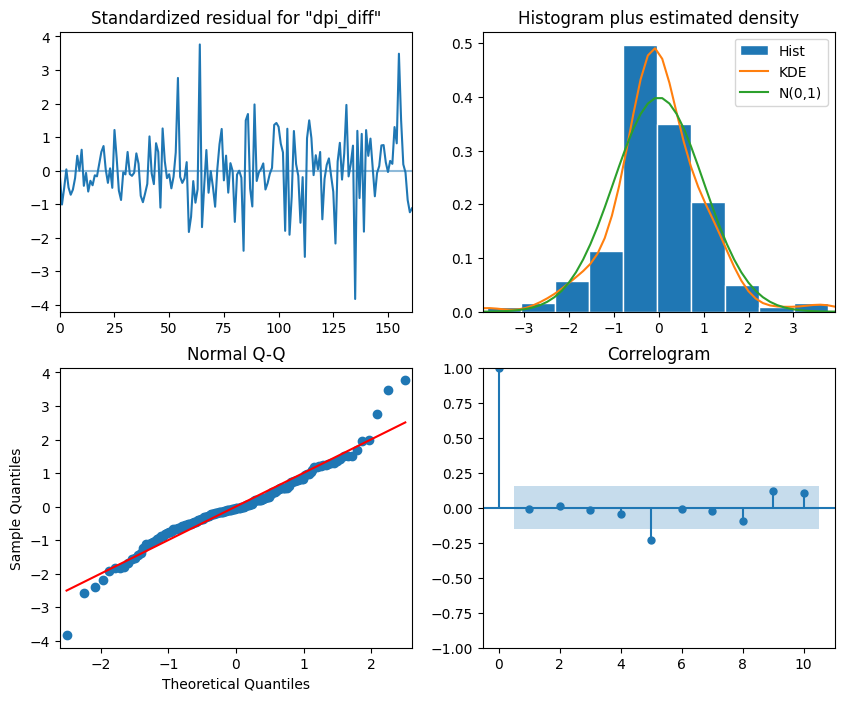

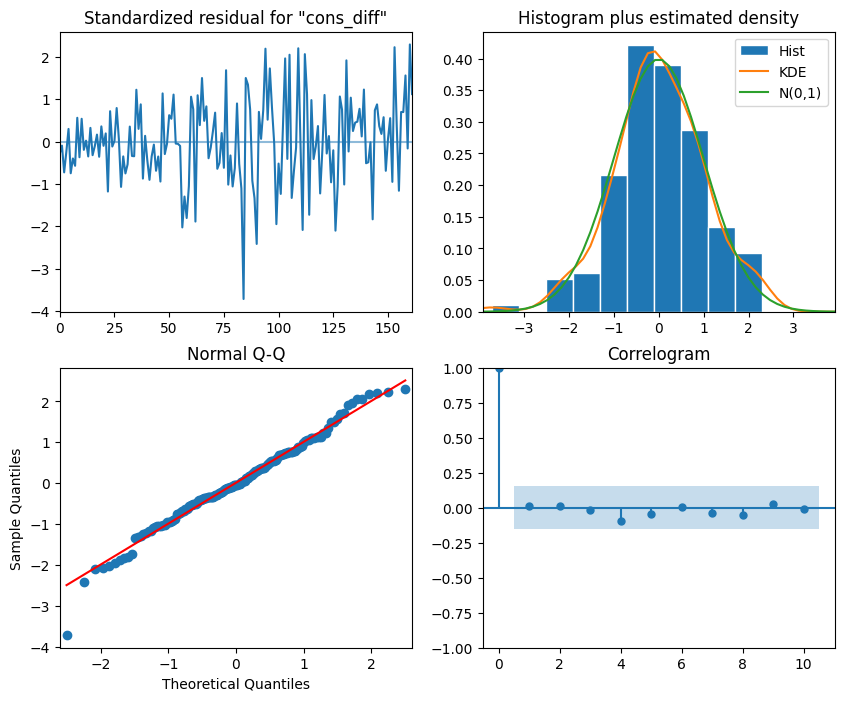

In [15]:
## Assessing the VARMA model ##
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assessing exogenous variables
VARMA_model_fit = VARMAX(train, order=(3, 0)).fit()
# print(VARMA_model_fit.summary())
VARMA_model_fit.plot_diagnostics(figsize=(10, 8), variable=0);    # Qualitative residual analysis on realdpi

# Intuition:
# top left: no trend in residual, variance fairly constant over time -> resembles white noise
# top right: fairly symmetrical distribution -> residuals are approximately normally distributed
# bottom left: fairly straight y=x line, but with curvature at extremities -> residuals seem to be normally distributed
# bottom right: no significant coefficient beyond lag 0, except lag 5 which is likely due to chance -> no autocorrelation
# Properties of white noice: normally distributed, stationary, uncorrelated
# Residuals resemble white noise -> errors are random

VARMA_model_fit.plot_diagnostics(figsize=(10, 8), variable=1);    # Qualitative residual analysis on realcons

# Intuition:
# top left: no trend in residual, variance fairly constant over time -> resembles white noise
# top right: fairly symmetrical distribution -> residuals are approximately normally distributed
# bottom left: fairly straight y=x line -> residuals seem to be normally distributed
# bottom right: no significant coefficient beyond lag 0 -> no autocorrelation
# Properties of white noice: normally distributed, stationary, uncorrelated
# Residuals resemble white noise -> errors are random

# Quantitative residual analysis - Ljung-Box test (model's residuals are uncorrelated?)
VARMA_residuals = VARMA_model_fit.resid
print(acorr_ljungbox(VARMA_residuals['dpi_diff'], 10))    # Ljung-Box test on realdpi residuals for 10 lags

# Intuition from Ljung-Box test:
# H0: residuals are iid, no autocorrelation
# All p-value > 0.05, cannot reject null hypothesis at each lag
# Conclude that residuals are uncorrelated
# realdpi residuals are completely random

print(acorr_ljungbox(VARMA_residuals['cons_diff'], 10))   # Ljung-Box test on realcons residuals for 10 lags

# Intuition from Ljung-Box test:
# H0: residuals are iid, no autocorrelation
# All p-value > 0.05, cannot reject null hypothesis at each lag
# Conclude that residuals are uncorrelated
# realcons residuals are completely random

# VARMA(3,0) model fits our data well

## Forecasting VARMA process

In [16]:
## Forecasting real disposable income and real consumption for next 1 year ##
from statsmodels.tsa.statespace.varmax import VARMAX

def rolling_forecast(endog,
                     train_len: int,
                     test_len: int,
                     window: int,
                     method: str) -> list:

    total_len = train_len + test_len

    # As time series increases by window period, new last value is extracted
    if method == 'last':
        dpi_pred_last = []
        cons_pred_last = []
        for i in range(train_len, total_len, window):
            dpi_last_value = endog.iloc[i-1]['realdpi']
            dpi_pred_last.extend([dpi_last_value] * window)
            cons_last_value = endog.iloc[i-1]['realcons']
            cons_pred_last.extend([cons_last_value] * window)
        return dpi_pred_last, cons_pred_last

    # As time series increases by window period, new VARMA is calculated
    elif method == 'VARMA':
        dpi_pred_varma = []
        cons_pred_varma = []
        for i in range(train_len, total_len, window):
            pred_varma_model = VARMAX(endog.iloc[:i], order=(3, 0))
            res = pred_varma_model.fit()
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred_readdpi = predictions.predicted_mean.iloc[-window:]['dpi_diff']
            oos_pred_readcons = predictions.predicted_mean.iloc[-window:]['cons_diff']
            dpi_pred_varma.extend(oos_pred_readdpi)
            cons_pred_varma.extend(oos_pred_readcons)
        return dpi_pred_varma, cons_pred_varma

# Forecasting using last value and VARMA(3,0)
TRAIN_LEN = len(train)
TEST_LEN = len(test)
WINDOW = 4      # to forecast 4 timestep into future (equivalent to 1 year)

# Note: input is actual data, since last value method don't require differencing
pred_last = rolling_forecast(gdp_df.loc[:,['realcons','realdpi']], TRAIN_LEN, TEST_LEN, WINDOW, 'last')

# Note: input is differenced data
pred_var = rolling_forecast(df_diff, TRAIN_LEN, TEST_LEN, WINDOW, 'VARMA')

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


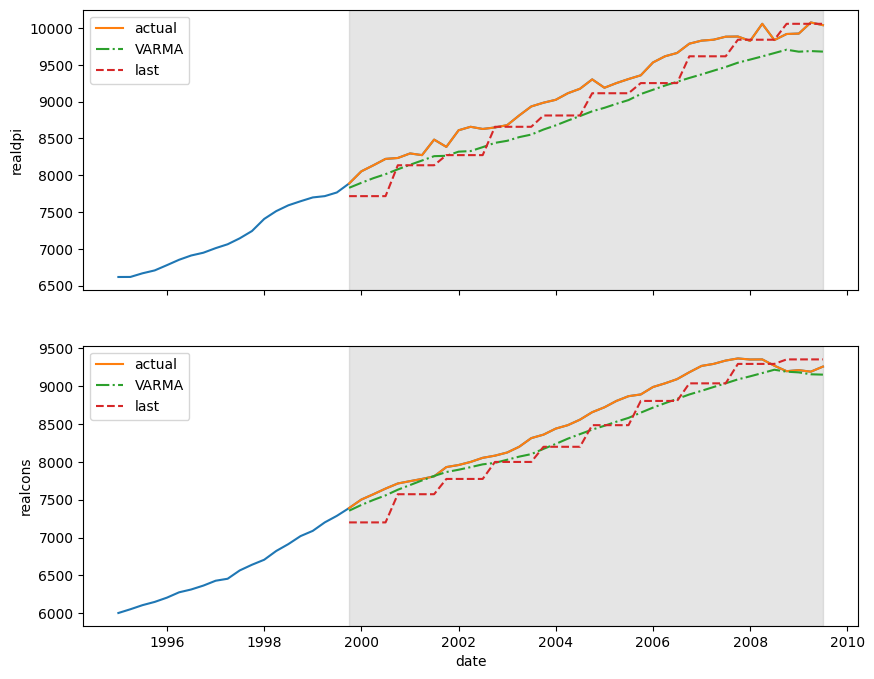

In [17]:
# Last 40 actual dataset
actual_test = gdp_df.iloc[163:][['date','realdpi','realcons']]

# 4 timestep rolling forecasted actual data
actual_test['realdpi_last'] = pd.Series(pred_last[0], index=actual_test.index)
actual_test['realcons_last'] = pd.Series(pred_last[1], index=actual_test.index)

# Inverse-transform the forecasted differenced dataset to original scale
actual_test['realdpi_varma'] = gdp_df.iloc[162]['realdpi'] + np.cumsum(pred_var[0])
actual_test['realcons_varma'] = gdp_df.iloc[162]['realcons'] + np.cumsum(pred_var[1])

# For diff dataset:
# 0 to 161 -> train set
# 162 to 201 -> test set
# Use first value's index of (diff) test set as initial Y_0 value index for inverse-transforming
# Then perform a cumulative sum

## Assessing prediction models ##
fig, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)

# Plot realdpi forecasts
sns.lineplot(data=gdp_df.loc[gdp_df.date>='1995',:], x='date', y='realdpi', ax=axs[0])
sns.lineplot(x=actual_test.date, y=actual_test.realdpi, label='actual', ax=axs[0])
sns.lineplot(x=actual_test.date, y=actual_test.realdpi_varma, label='VARMA', linestyle='dashdot', ax=axs[0])
sns.lineplot(x=actual_test.date, y=actual_test.realdpi_last, label='last', linestyle='dashed', ax=axs[0])
axs[0].axvspan(datetime.datetime(1999,10,1), datetime.datetime(2009,7,1), color='grey', alpha=0.2)

# Plot realcons forecasts
sns.lineplot(data=gdp_df.loc[gdp_df.date>='1995',:], x='date', y='realcons', ax=axs[1])
sns.lineplot(x=actual_test.date, y=actual_test.realcons, label='actual', ax=axs[1])
sns.lineplot(x=actual_test.date, y=actual_test.realcons_varma, label='VARMA', linestyle='dashdot', ax=axs[1])
sns.lineplot(x=actual_test.date, y=actual_test.realcons_last, label='last', linestyle='dashed', ax=axs[1])
axs[1].axvspan(datetime.datetime(1999,10,1), datetime.datetime(2009,7,1), color='grey', alpha=0.2)

# Intuition from forecast graph:
# VARMA graphs follow general trend of observed values
# Baseline graphs move in steps, as we are forecasting constant value over 4 timesteps

# Calculating MAPE
# Reporting values and errors in original scale of data to make sense from business perspective
from sklearn.metrics import mean_absolute_percentage_error

mape_realdpi_varma = mean_absolute_percentage_error(actual_test.realdpi, actual_test.realdpi_varma)
mape_realdpi_last = mean_absolute_percentage_error(actual_test.realdpi, actual_test.realdpi_last)

mape_realcons_varma = mean_absolute_percentage_error(actual_test.realcons, actual_test.realcons_varma)
mape_realcons_last = mean_absolute_percentage_error(actual_test.realcons, actual_test.realcons_last)

Text(0.5, 1.0, 'realcons')

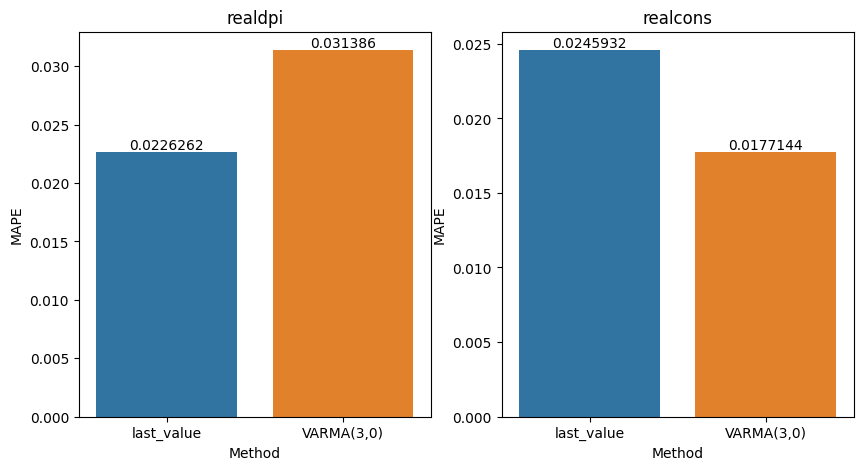

In [18]:
# Plot MAPEs
mape_realdpi = {
    'name':['last_value', 'VARMA(3,0)'],
    'mape':[mape_realdpi_last, mape_realdpi_varma]
    }

mape_realcons = {
    'name':['last_value', 'VARMA(3,0)'],
    'mape':[mape_realcons_last, mape_realcons_varma]
    }

_, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(data=mape_realdpi, x='name', y='mape', ax=axs[0])
sns.barplot(data=mape_realcons, x='name', y='mape', ax=axs[1])
for ax in axs:
    ax.set_xlabel('Method')
    ax.set_ylabel('MAPE')
    ax.bar_label(ax.containers[0])
axs[0].set_title('realdpi')
axs[1].set_title('realcons')

# Intuition:
# VAR(3) model performs worse than the baseline for forecasting realdpi.
# VAR(3) model performs better than the baseline for forecasting realcons.
# We hypothesize that in the case of realdpi, realcons is not predictive enough to
# make more accurate forecasts than the baseline, even though the Granger causality test passed.
# > Conclude that VAR(3) model is not sufficient to accurately forecast realdpi and realcons.
# > To use a variation of the SARIMAX model to predict realdpi: use two separate models,
# > which could include realdpi and realcons as exogenous variables,
# > while also potentially including moving average terms.

# Vector Autoregression Moving Average Model Exogenous

## Identifying VARMAX process

In [19]:
## To forecast both real disposable income and real consumption using VARMAX ##
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# Import data
gdp_df = sm.datasets.macrodata.load_pandas().data
gdp_df['date'] = pd.to_datetime(gdp_df.year.astype(int).astype(str) + 'Q' + gdp_df.quarter.astype(int).astype(str))

# Applying first order differencing to endogenous variables
dpi_diff = np.diff(gdp_df['realdpi'], n=1)
cons_diff = np.diff(gdp_df['realcons'], n=1)

In [20]:
# Spliting differenced dataset into train & test sets
df_diff = pd.DataFrame({'dpi_diff': dpi_diff, 'cons_diff': cons_diff})
train_endog = df_diff.loc[:161,]
test_endog = df_diff.loc[162:,]

# Defining exogenous variables (Exogenous variables don't need to be stationary)
df_exog = gdp_df.drop(['year', 'quarter', 'realdpi', 'realcons', 'date'], axis=1)
train_exog = df_exog.loc[:161,]

In [21]:
## Determining the order p, q for VARMAX process ##
from itertools import product
from statsmodels.tsa.statespace.varmax import VARMAX

# Fitting data to all unique VARMAX(p,q) models
def optimise_VARMAX(endog, exog, order_list) -> pd.DataFrame:
    """
    Args:
        endog: endogenous data to be fitted
        exog: exogenous data to be fitted
        order_list: list of possible (p,q) values

    Returns: DataFrame containing AIC results for different (p,q) orders
    """
    results = []

    for p, q in order_list:
            model = VARMAX(endog, exog, order=(p, q)).fit()
            aic = model.aic
            results.append([(p,q), aic])

    result_df = pd.DataFrame(results, columns=['(p,q)', 'AIC']).sort_values(by='AIC').reset_index(drop=True)

    return result_df

# Defining posssible values of p, q (0 to 3)
VARMAX_order_list = list(product(range(0,4), repeat=2))[1:]  # VARMAX cannot take in (0,0) as order

# Using Akaike information criterion to select optimal model
AIC_result = optimise_VARMAX(train_endog, train_exog, VARMAX_order_list)
AIC_result

# Intuition:
# Select VARMAX(1,0) as optimal model since it has the lowest AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/pyt

,"(p,q)",AIC
0,"(1, 0)",3070.660060
1,"(2, 0)",3078.473348
2,"(1, 1)",3078.573199
3,"(0, 1)",3079.401700
4,"(3, 0)",3084.069521
5,"(1, 2)",3086.180312
6,"(0, 2)",3086.279542
7,"(2, 1)",3086.329117
8,"(1, 3)",3090.279741
9,"(3, 1)",3092.696101


In [22]:
## Determine whether one time series is predictive of another ##
from statsmodels.tsa.stattools import grangercausalitytests

# Applying Granger causality test on whole differenced data (ie. train + test)
# H0: second column does not Granger-cause first column
granger_1 = grangercausalitytests(df_diff, [1])                                     # only at lag 1
granger_2 = grangercausalitytests(df_diff.loc[:, ['cons_diff', 'dpi_diff']], [1])   # Use the largest order among (p,q)

# Intuition:
# test 1: All p-value < 0.05
# Reject H0 and conclude realcons Granger-causes realdpi
# test 2:  0.06 > All p-value > 0.05
# Since p-values only very slightly > 0.05, reject H0 and conclude realdpi Granger-causes realcons
# Can consider VARMAX(1,0) model to still be valid


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=35.3881 , p=0.0000  , df=1
likelihood ratio test: chi2=32.5962 , p=0.0000  , df=1
parameter F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=7.8540  , p=0.0051  , df=1
likelihood ratio test: chi2=7.7045  , p=0.0055  , df=1
parameter F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1


      lb_stat  lb_pvalue
1    0.001733   0.966791
2    0.013971   0.993039
3    1.023481   0.795570
4    2.553738   0.635040
5   17.122345   0.004274
6   18.224342   0.005695
7   18.637895   0.009401
8   18.858785   0.015633
9   20.417465   0.015504
10  21.856828   0.015851
     lb_stat  lb_pvalue
1   0.040890   0.839751
2   0.041059   0.979680
3   0.834550   0.841186
4   3.198919   0.525106
5   5.205027   0.391374
6   5.210870   0.517066
7   6.500021   0.482721
8   8.768946   0.362161
9   8.943397   0.442515
10  8.967620   0.535179


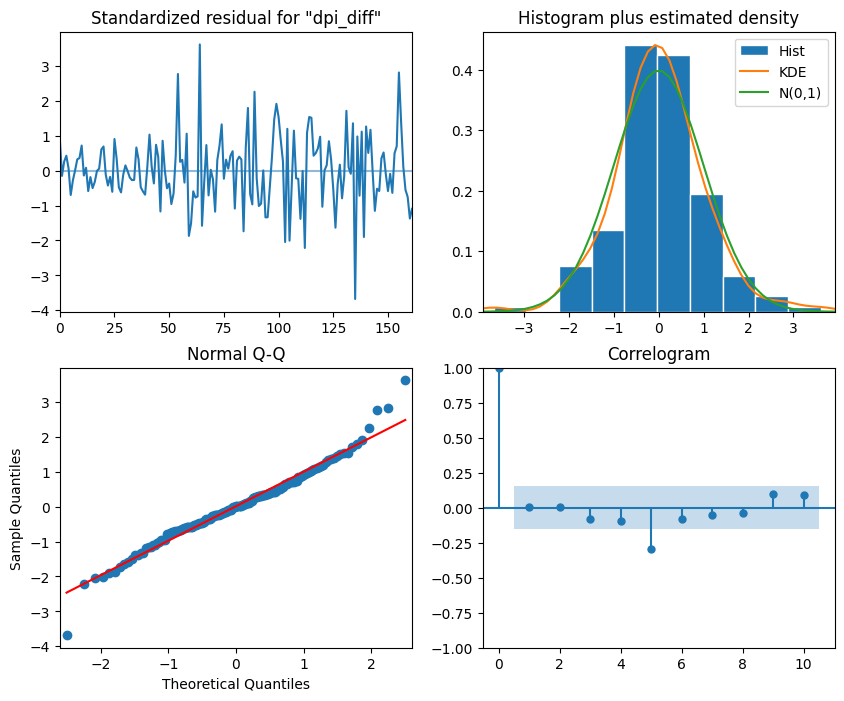

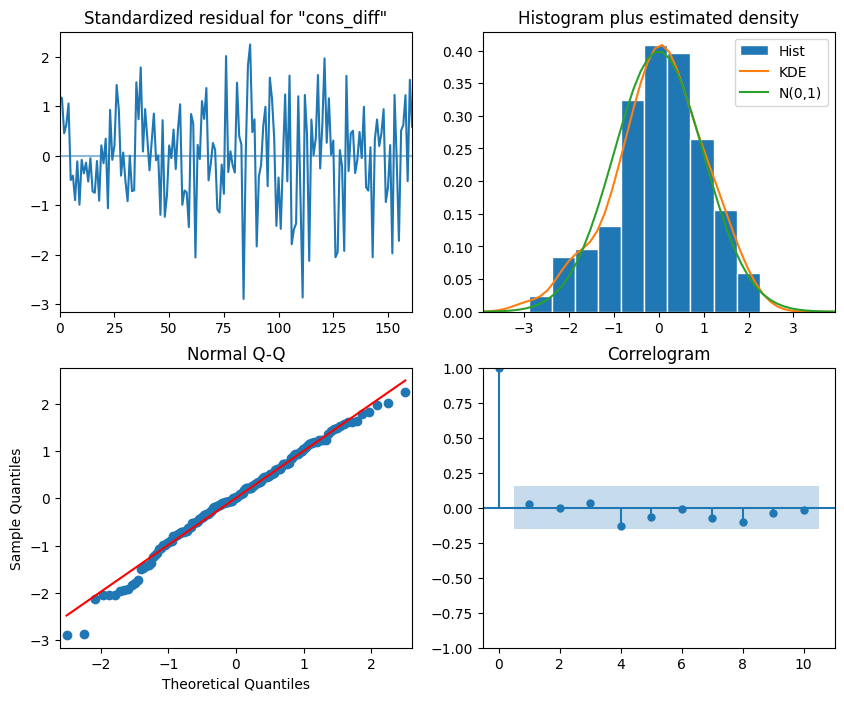

In [23]:
## Assessing the VARMA model ##
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assessing exogenous variables
VARMAX_model_fit = VARMAX(train_endog, train_exog, order=(1, 0)).fit()
# print(VARMAX_model_fit.summary())
VARMAX_model_fit.plot_diagnostics(figsize=(10, 8), variable=0);    # Qualitative residual analysis on realdpi

# Intuition:
# top left: no trend in residual, variance fairly constant over time -> resembles white noise
# top right: fairly symmetrical distribution -> residuals are approximately normally distributed
# bottom left: fairly straight y=x line, but with curvature at extremities -> residuals seem to be normally distributed
# bottom right: no significant coefficient beyond lag 0, except lag 5 which is likely due to chance -> no autocorrelation
# Properties of white noice: normally distributed, stationary, uncorrelated
# Residuals resemble white noise -> errors are random

VARMAX_model_fit.plot_diagnostics(figsize=(10, 8), variable=1);    # Qualitative residual analysis on realcons

# Intuition:
# top left: no trend in residual, variance fairly constant over time -> resembles white noise
# top right: fairly symmetrical distribution -> residuals are approximately normally distributed
# bottom left: fairly straight y=x line -> residuals seem to be normally distributed
# bottom right: no significant coefficient beyond lag 0 -> no autocorrelation
# Properties of white noice: normally distributed, stationary, uncorrelated
# Residuals resemble white noise -> errors are random

# Quantitative residual analysis - Ljung-Box test (model's residuals are uncorrelated?)
VARMAX_residuals = VARMAX_model_fit.resid
print(acorr_ljungbox(VARMAX_residuals['dpi_diff'], 10))    # Ljung-Box test on realdpi residuals for 10 lags

# Intuition from Ljung-Box test:
# H0: residuals are iid, no autocorrelation
# p-value at lag 5 < 0.05, reject null hypothesis at lag 5
# Conclude that residuals seem to be correlated at lag 5
# (keep going for sake of finishing the exercise)

print(acorr_ljungbox(VARMAX_residuals['cons_diff'], 10))   # Ljung-Box test on realcons residuals for 10 lags

# Intuition from Ljung-Box test:
# H0: residuals are iid, no autocorrelation
# All p-value > 0.05, cannot reject null hypothesis at each lag
# Conclude that residuals are uncorrelated
# realcons residuals are completely random

# VARMAX(1,0) model somewhat fits our data well?

## Forecasting VARMAX process

In [24]:
## Forecasting real disposable income and real consumption for next 1 year ##
from statsmodels.tsa.statespace.varmax import VARMAX

def rolling_forecast(endog,
                     exog,
                     train_len: int,
                     test_len: int,
                     window: int,
                     method: str) -> list:

    total_len = train_len + test_len

    # As time series increases by window period, new last value is extracted
    if method == 'last':
        dpi_pred_last = []
        cons_pred_last = []
        for i in range(train_len, total_len, window):
            dpi_last_value = endog.iloc[i-1]['realdpi']
            dpi_pred_last.extend([dpi_last_value] * window)
            cons_last_value = endog.iloc[i-1]['realcons']
            cons_pred_last.extend([cons_last_value] * window)
        return dpi_pred_last, cons_pred_last

    # As time series increases by window period, new VARMAX is calculated
    elif method == 'VARMAX':
        dpi_pred_varmax = []
        cons_pred_varmax = []
        for i in range(train_len, total_len, window):
            pred_varmax_model = VARMAX(endog.iloc[:i,], exog.iloc[:i,], order=(1, 0))
            res = pred_varmax_model.fit()
            predictions = res.get_prediction(0, i + window - 1, exog=exog.iloc[-1])     # exog takes shape of 1 row of observation only <- (bug)
            oos_pred_readdpi = predictions.predicted_mean.iloc[-window:]['dpi_diff']
            oos_pred_readcons = predictions.predicted_mean.iloc[-window:]['cons_diff']
            dpi_pred_varmax.extend(oos_pred_readdpi)
            cons_pred_varmax.extend(oos_pred_readcons)
        return dpi_pred_varmax, cons_pred_varmax

# Forecasting using last value and VARMA(3,0)
TRAIN_LEN = len(train_endog)
TEST_LEN = len(test_endog)
WINDOW = 1      # With exogenous variables, can only predict the next timestep (like SARIMAX)

# Note: input is actual data, since last value method don't require differencing
pred_last = rolling_forecast(gdp_df.loc[:,['realcons','realdpi']], [], TRAIN_LEN, TEST_LEN, WINDOW, 'last')

# Note: input is differenced data
pred_var = rolling_forecast(df_diff, df_exog.iloc[1:,].reset_index(drop=True), TRAIN_LEN, TEST_LEN, WINDOW, 'VARMAX')        # df_exog has 1 more row than df_diff -> remove row 0 (like differencing)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


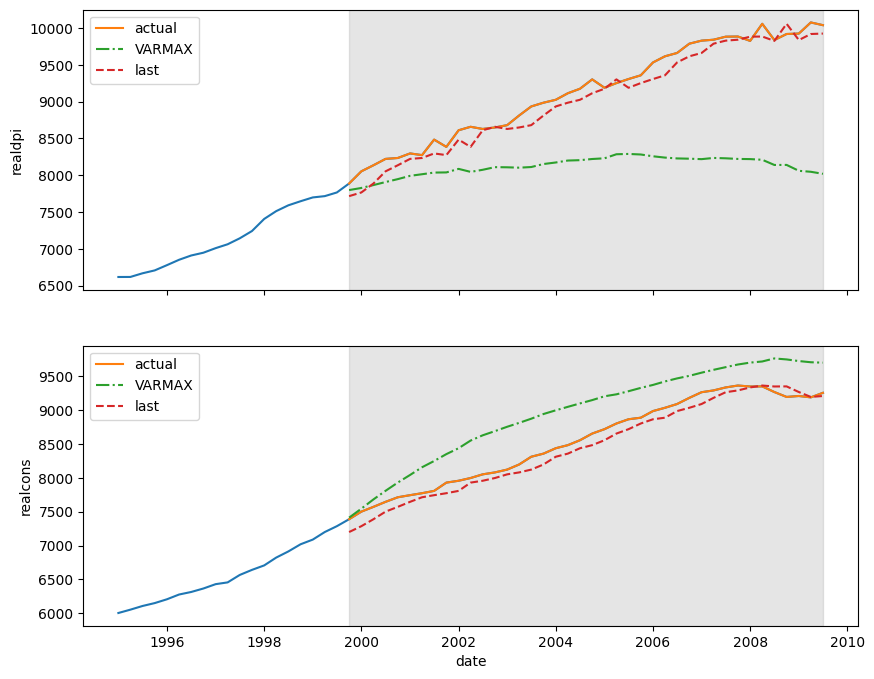

In [25]:
# Last 40 actual dataset
actual_test = gdp_df.iloc[163:][['date','realdpi','realcons']]

# 4 timestep rolling forecasted actual data
actual_test['realdpi_last'] = pd.Series(pred_last[0], index=actual_test.index)
actual_test['realcons_last'] = pd.Series(pred_last[1], index=actual_test.index)

# Inverse-transform the forecasted differenced dataset to original scale
actual_test['realdpi_varmax'] = gdp_df.iloc[162]['realdpi'] + np.cumsum(pred_var[0])
actual_test['realcons_varmax'] = gdp_df.iloc[162]['realcons'] + np.cumsum(pred_var[1])

# For diff dataset:
# 0 to 161 -> train set
# 162 to 201 -> test set
# Use first value's index of (diff) test set as initial Y_0 value index for inverse-transforming
# Then perform a cumulative sum

## Assessing prediction models ##
fig, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)

# Plot realdpi forecasts
sns.lineplot(data=gdp_df.loc[gdp_df.date>='1995',:], x='date', y='realdpi', ax=axs[0])
sns.lineplot(x=actual_test.date, y=actual_test.realdpi, label='actual', ax=axs[0])
sns.lineplot(x=actual_test.date, y=actual_test.realdpi_varmax, label='VARMAX', linestyle='dashdot', ax=axs[0])
sns.lineplot(x=actual_test.date, y=actual_test.realdpi_last, label='last', linestyle='dashed', ax=axs[0])
axs[0].axvspan(datetime.datetime(1999,10,1), datetime.datetime(2009,7,1), color='grey', alpha=0.2)

# Plot realcons forecasts
sns.lineplot(data=gdp_df.loc[gdp_df.date>='1995',:], x='date', y='realcons', ax=axs[1])
sns.lineplot(x=actual_test.date, y=actual_test.realcons, label='actual', ax=axs[1])
sns.lineplot(x=actual_test.date, y=actual_test.realcons_varmax, label='VARMAX', linestyle='dashdot', ax=axs[1])
sns.lineplot(x=actual_test.date, y=actual_test.realcons_last, label='last', linestyle='dashed', ax=axs[1])
axs[1].axvspan(datetime.datetime(1999,10,1), datetime.datetime(2009,7,1), color='grey', alpha=0.2)

# Intuition from forecast graph:
# VARMAX graphs defers from the general trend of observed values
# As compared to VARMAX graph, baseline graph sticks closer to actual graph

# Calculating MAPE
# Reporting values and errors in original scale of data to make sense from business perspective
from sklearn.metrics import mean_absolute_percentage_error

mape_realdpi_varmax = mean_absolute_percentage_error(actual_test.realdpi, actual_test.realdpi_varmax)
mape_realdpi_last = mean_absolute_percentage_error(actual_test.realdpi, actual_test.realdpi_last)

mape_realcons_varmax = mean_absolute_percentage_error(actual_test.realcons, actual_test.realcons_varmax)
mape_realcons_last = mean_absolute_percentage_error(actual_test.realcons, actual_test.realcons_last)

Text(0.5, 1.0, 'realcons')

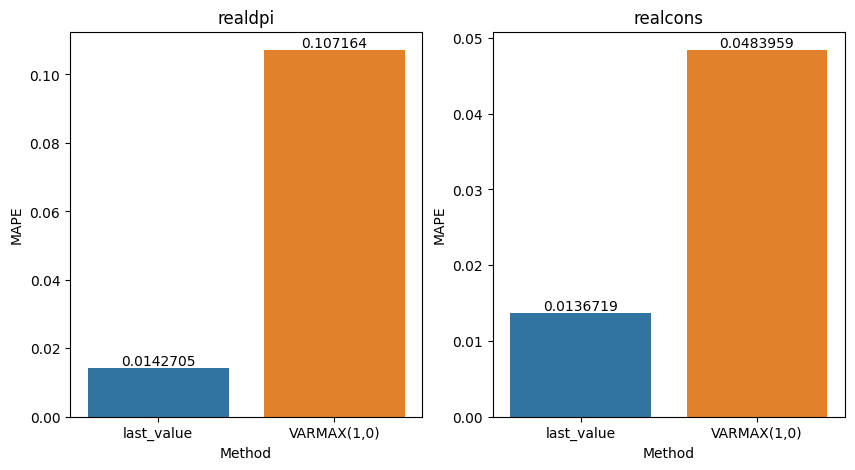

In [26]:
# Plot MAPEs
mape_realdpi = {
    'name':['last_value', 'VARMAX(1,0)'],
    'mape':[mape_realdpi_last, mape_realdpi_varmax]
    }

mape_realcons = {
    'name':['last_value', 'VARMAX(1,0)'],
    'mape':[mape_realcons_last, mape_realcons_varmax]
    }

_, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(data=mape_realdpi, x='name', y='mape', ax=axs[0])
sns.barplot(data=mape_realcons, x='name', y='mape', ax=axs[1])
for ax in axs:
    ax.set_xlabel('Method')
    ax.set_ylabel('MAPE')
    ax.bar_label(ax.containers[0])
axs[0].set_title('realdpi')
axs[1].set_title('realcons')

# Intuition:
# VARAMX(1,0) model performs worse than the baseline for both realdpi & realcons.
# Conclude that VARAMX(1,0) model is not useful in forecasting realdpi and realcons.
# Note: cannot compare VARMAX to VAR, since different forecast window is used.


# Appendix

Everything here is based on textbook:
* Time Series Forecasting in Python - Marco Peixeiro